# Task 1: Exploratory Analysis of Train Delays and Cancellations  
## Model Initiation Phase (AI Lifecycle)

This notebook corresponds to Task 1 of the Applied AI final case study and implements the Model Initiation phase of the AI lifecycle.  
The goal of this task is not to build predictive models yet, but to establish a **data-driven understanding of delay and cancellation risks** in the German railway system and to prepare a reliable foundation for later modelling (Task 2 & 3).

We use the Deutsche Bahn dataset provided by Piet Brömmel and enrich it with additional contextual data (e.g. weather and station information) in order to uncover structural patterns in the data.


## Research Objective

The central objective of Task 1 is to identify **systematic, interpretable patterns** in delays and cancellations that can later be used as features or modelling assumptions in predictive and classification tasks.

In particular, We aim to understand:
- when delays and cancellations are more likely to occur,
- where in the network risks are concentrated,
- and how external conditions (such as weather and seasonality) influence operational reliability.


## Research Hypotheses

Based on domain knowledge about railway operations and initial exploratory statistics, I formulate the following hypotheses:

**H1: Spatial risk clustering**  
> Cancellation risk is spatially clustered, meaning that certain stations or regions exhibit systematically higher cancellation rates than others.

**H2: Seasonal and weather effects**  
> Cancellation risk increases during low temperatues and under adverse weather conditions such as rain and snow.

These hypotheses will guide the subsequent data preparation, feature engineering, and exploratory analysis.  
All patterns and visualisations presented in this notebook are designed to test and support (or reject) these hypotheses in a controlled, reproducible manner.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Daily, Hourly
import geopandas as gpd
import pyarrow as pa
from sklearn import datasets, model_selection, metrics
import requests


In [2]:
files = [
    "data-2025-01.parquet",
    "data-2025-02.parquet",
    "data-2025-06.parquet",
    "data-2025-07.parquet",
    "data-2025-08.parquet",
    "data-2025-12.parquet",
]

df_raw = pd.concat([pd.read_parquet(f"data/{f}") for f in files])


In [3]:
df_raw["month"] = df_raw["time"].dt.month
df_raw["month"].value_counts(normalize=True)


month
12    0.612418
7     0.079998
1     0.079877
8     0.078526
6     0.076104
2     0.073077
Name: proportion, dtype: float64

In [4]:
df_raw.columns


Index(['station_name', 'xml_station_name', 'eva', 'train_name',
       'final_destination_station', 'delay_in_min', 'time', 'is_canceled',
       'train_type', 'train_line_ride_id', 'train_line_station_num',
       'arrival_planned_time', 'arrival_change_time', 'departure_planned_time',
       'departure_change_time', 'id', 'month'],
      dtype='object')

In [5]:
print("Total observations (rows):", len(df_raw))
print("Number of variables (columns):", df_raw.shape[1])


Total observations (rows): 25249841
Number of variables (columns): 17


In [6]:
print("Unique stations (EVA):", df_raw["eva"].nunique())
print("Unique station names:", df_raw["station_name"].nunique())

print("Unique trains (train_line_ride_id):", df_raw["train_line_ride_id"].nunique())
print("Unique train names:", df_raw["train_name"].nunique())


Unique stations (EVA): 5372
Unique station names: 5326
Unique trains (train_line_ride_id): 81119
Unique train names: 2699


In [7]:
df_raw["month"].value_counts().sort_index()


month
1      2016880
2      1845194
6      1921604
7      2019926
8      1982770
12    15463467
Name: count, dtype: int64

In [8]:
df_raw["is_canceled"].value_counts(normalize=True)

df_raw["delay_in_min"].describe(percentiles=[0.5, 0.9, 0.95, 0.99])


count    2.524984e+07
mean     3.373939e+00
std      8.359704e+00
min     -1.389000e+03
50%      1.000000e+00
90%      8.000000e+00
95%      1.500000e+01
99%      3.800000e+01
max      8.680000e+02
Name: delay_in_min, dtype: float64

In [9]:
trains_per_month = (
    df_raw
    .groupby("month")["train_line_ride_id"]
    .nunique()
    .sort_index()
)

trains_per_month


month
1     28751
2     28605
6     29541
7     29202
8     30560
12    46774
Name: train_line_ride_id, dtype: int64

In [10]:
stations_per_month = (
    df_raw
    .groupby("month")["eva"]
    .nunique()
    .sort_index()
)

stations_per_month


month
1      131
2      131
6      131
7      131
8      130
12    5372
Name: eva, dtype: int64

In [1]:
type_stats = (
    df.groupby("train_type")
      .agg(
          type_mean_delay=("delay_in_min_clean", "mean"),
          type_cancel_rate=("is_cancelled", "mean")
      )
      .reset_index()
)


NameError: name 'df' is not defined

## Summary of Data Gathering and Distribution

The raw dataset contains more than 25 million train stop events and covers a very large and heterogeneous railway network:

- **5,372 unique stations (EVA codes)**
- **81,119 unique train rides**
- **2,699 unique train names**

However, a closer inspection of the temporal and spatial distribution reveals a severe imbalance across months.

### Temporal coverage

The dataset includes six months: January, February, June, July, August, and December 2025.  
While the number of unique train rides is relatively stable across months (≈ 28,000–30,000), the number of recorded stop events is extremely uneven.

December alone accounts for more than **60% of all observations**.

### Spatial coverage

Even more striking is the spatial imbalance:

| Month | Unique stations |
|------|-----------------|
| Jan, Feb, Jun, Jul | ~131 |
| Aug | 130 |
| **Dec** | **5,372** |

This means that December contains data from **almost the entire German railway network**, whereas the other months only cover a small subset of stations.  
Without correction, any spatial or seasonal analysis would be dominated by December and would conflate true winter effects with differences in network coverage.

### Implication

The raw dataset is therefore **not directly suitable** for hypothesis testing about spatial clustering or seasonal and weather effects.  
A controlled sampling strategy is required to ensure that all months contribute comparably and that station-level risk patterns are not artificially created by uneven data coverage.

For this reason, we now proceed to a **stratified sampling step** to construct a balanced and representative subset of the data.

In [11]:
stations_by_month = (
    df_raw
    .groupby("month")["eva"]
    .apply(set)
)


In [12]:
core_stations = (
    stations_by_month[1]
    & stations_by_month[2]
    & stations_by_month[6]
    & stations_by_month[7]
    & stations_by_month[8]
)
len(core_stations)


130

In [13]:
df_panel = df_raw[df_raw["eva"].isin(core_stations)].copy()


I observed that January–August form a stable panel of approximately 130 stations, whereas December contains almost the full German railway network. To avoid confounding seasonal effects with changes in network coverage, we construct a balanced station panel by restricting all months, including December, to this shared set of stations. We do not apply simple stratified or random sampling. Instead, we construct a balanced station panel.

We treat each railway station (EVA code) as a cluster and restrict the dataset to the subset of stations that are observed in all months. This ensures that spatial patterns and seasonal effects are not confounded by changes in network coverage.

Methodologically, this corresponds to a form of cluster sampling with deterministic cluster selection, resulting in a longitudinal panel of approximately 130 stations observed consistently across all months.

In [14]:
df_panel["is_canceled"].value_counts(normalize=True)
df_panel["delay_in_min"].describe([0.5, 0.9, 0.95, 0.99])
df_panel["month"].value_counts()


month
7     2003971
1     1993404
12    1986819
8     1982770
6     1901559
2     1827201
Name: count, dtype: int64

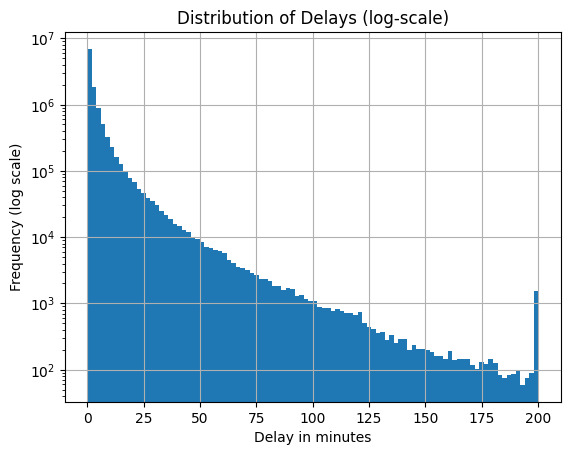

In [15]:
df_panel["delay_in_min"].clip(0, 200).hist(bins=100)

plt.yscale("log")   
plt.title("Distribution of Delays (log-scale)")
plt.xlabel("Delay in minutes")
plt.ylabel("Frequency (log scale)")

plt.show()


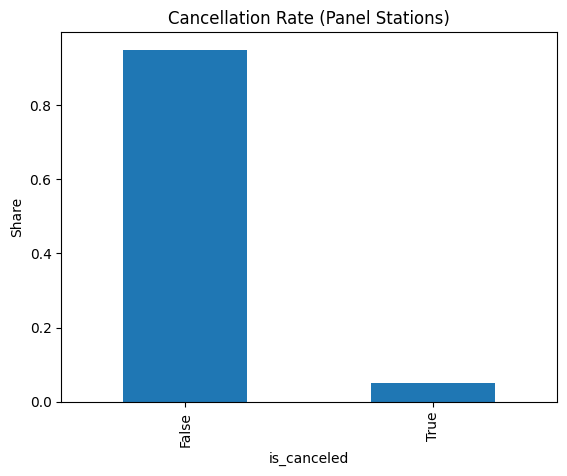

In [16]:
df_panel["is_canceled"].value_counts(normalize=True).plot(kind="bar")
plt.title("Cancellation Rate (Panel Stations)")
plt.ylabel("Share")
plt.show()


In [17]:
df_panel["season"] = df_panel["month"].apply(
    lambda m: "winter" if m in [12,1,2] else "summer"
)


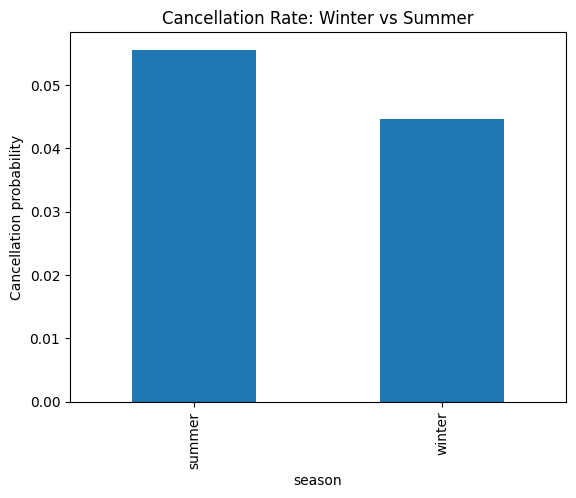

In [18]:
df_panel.groupby("season")["is_canceled"].mean().plot(kind="bar")
plt.title("Cancellation Rate: Winter vs Summer")
plt.ylabel("Cancellation probability")
plt.show()


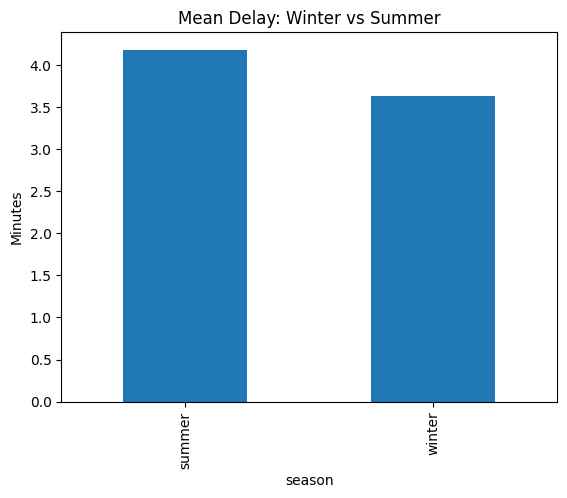

In [19]:
df_panel.groupby("season")["delay_in_min"].mean().plot(kind="bar")
plt.title("Mean Delay: Winter vs Summer")
plt.ylabel("Minutes")
plt.show()


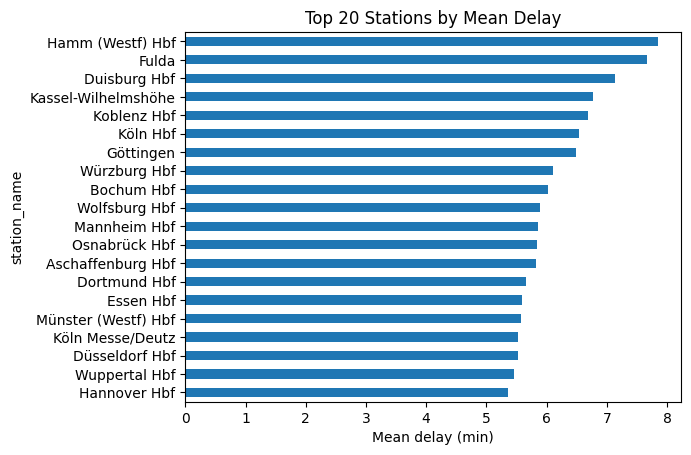

In [20]:
station_delay = (
    df_panel
    .groupby("station_name")["delay_in_min"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

station_delay.plot(kind="barh")
plt.title("Top 20 Stations by Mean Delay")
plt.xlabel("Mean delay (min)")
plt.gca().invert_yaxis()
plt.show()


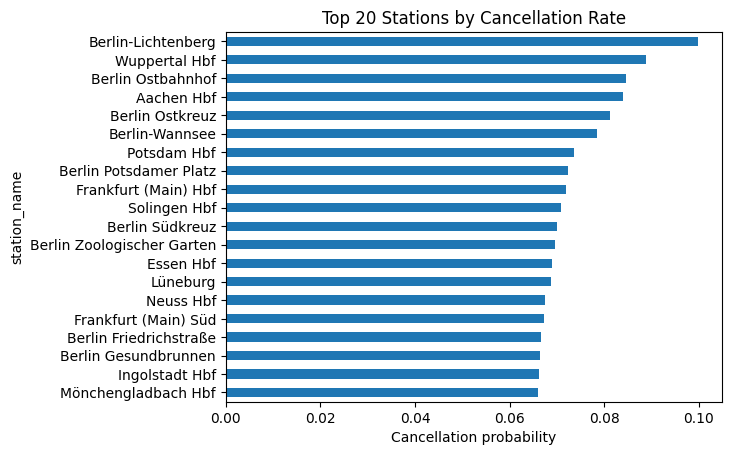

In [21]:
station_cancel = (
    df_panel
    .groupby("station_name")["is_canceled"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

station_cancel.plot(kind="barh")
plt.title("Top 20 Stations by Cancellation Rate")
plt.xlabel("Cancellation probability")
plt.gca().invert_yaxis()
plt.show()


In [22]:

(df_panel["delay_in_min"] == 0).mean()


np.float64(0.36309261401859344)

In [23]:
df_panel["is_canceled"].mean()


np.float64(0.050153286790967366)

In [24]:
df_panel["delay_in_min"].describe([0.5, 0.9, 0.95, 0.99])


count    1.169572e+07
mean     3.909511e+00
std      1.013005e+01
min     -1.389000e+03
50%      1.000000e+00
90%      1.000000e+01
95%      1.800000e+01
99%      4.700000e+01
max      8.680000e+02
Name: delay_in_min, dtype: float64

In [33]:
#Early trains
(df_panel["delay_in_min"] < 0).mean()


np.float64(0.022343636016034576)

In [34]:
#Extreme outliers
(df_panel["delay_in_min"] > 180).mean()


np.float64(0.00019006946470351044)

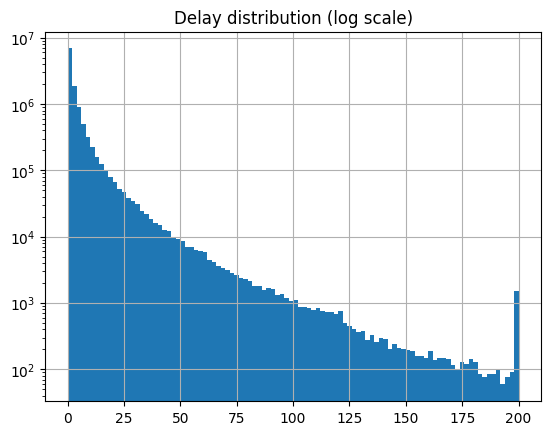

In [35]:
df_panel["delay_in_min"].clip(0, 200).hist(bins=100)
plt.yscale("log")
plt.title("Delay distribution (log scale)")
plt.show()


## Data Quality: Sparsity and Noise

The balanced station panel exhibits realistic but challenging data characteristics.

Approximately **36%** of all train stop events have a delay of exactly zero, indicating a high level of sparsity. This reflects the fact that many trains are on time or only marginally delayed.

About **2.2%** of all observations show negative delays (early arrivals), which are likely due to measurement noise or reporting artefacts in the operational data.

Only around **0.02%** of all observations have extreme delays above 180 minutes, confirming that the delay distribution is strongly right-skewed and heavy-tailed.

For the classification target, approximately **5%** of all observations correspond to cancelled trains. This indicates a moderately imbalanced classification problem, which will need to be taken into account in Task 3 when choosing models, loss functions, and evaluation metrics.

Overall, these properties are typical for real-world transportation data and imply that later regression and classification models must be robust to sparsity, class imbalance, and heavy-tailed noise.


In [37]:
df_panel["delay_in_min_clean"] = df_panel["delay_in_min"].clip(lower=0)


Now we incorpoate geo and weatherdata to enrich the original dataset

In [26]:
OSM_PATH = "data/stations/osm_germany_stations.geojson"


In [27]:
gdf_osm = gpd.read_file(OSM_PATH)

# Ensure point geometry
gdf_osm = gdf_osm[gdf_osm.geometry.notna()].copy()

# lat/lon from geometry
gdf_osm["lon"] = gdf_osm.geometry.x
gdf_osm["lat"] = gdf_osm.geometry.y

gdf_osm.columns, len(gdf_osm)


(Index(['id', '@id', 'FIXME', 'FIXME:DE', 'TMC:cid_58:tabcd_1:Class',
        'TMC:cid_58:tabcd_1:LCLversion', 'TMC:cid_58:tabcd_1:LocationCode',
        'VRS:gemeinde', 'VRS:name', 'VRS:ortsteil',
        ...
        'wikipedia', 'wikipedia:de', 'wikipedia:en', 'wikipedia:fr',
        'wikipedia:nl', 'workrules', 'zone', 'geometry', 'lon', 'lat'],
       dtype='object', length=376),
 3746)

In [28]:
DELAY_COL  = "delay_in_min"
CANCEL_COL = "is_canceled"
EVA_COL    = "eva"
NAME_COL   = "station_name"
ID_COL     = "id"

df = df_panel.copy()

# minimal preprocessing for delay
df["delay_pos"] = df[DELAY_COL].clip(lower=0)

station_stats = (
    df.groupby([EVA_COL, NAME_COL])
      .agg(
          traffic_volume=(ID_COL, "count"),
          cancel_rate=(CANCEL_COL, "mean"),
          mean_delay=("delay_pos", "mean"),
          share_gt15=("delay_pos", lambda x: (x > 15).mean()),
          share_gt30=("delay_pos", lambda x: (x > 30).mean()),
          p90_delay=("delay_pos", lambda x: x.quantile(0.90)),
      )
      .reset_index()
)

station_stats.sort_values("traffic_volume", ascending=False).head()


,eva,station_name,traffic_volume,cancel_rate,mean_delay,share_gt15,share_gt30,p90_delay
110,08089028,Berlin Ostkreuz,289503,0.082942,1.358380,0.008774,0.001126,3.0
113,08089066,Berlin Friedrichstraße,255349,0.072133,1.585422,0.009399,0.001269,4.0
15,08000085,Düsseldorf Hbf,249804,0.057405,5.554983,0.098773,0.036132,15.0
128,08098549,Hamburg Hbf,217549,0.022556,2.313185,0.015151,0.003080,5.0
45,08000207,Köln Hbf,217042,0.062384,6.584117,0.115402,0.043950,18.0


In [29]:
station_stats = station_stats[station_stats["traffic_volume"] >= 10_000].copy()


In [30]:
import re
def clean_name(s: str) -> str:
    if pd.isna(s):
        return ""
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    s = s.replace("hbf", "hauptbahnhof")
    s = s.replace("bf", "bahnhof")
    s = re.sub(r"[^a-z0-9äöüß \-]", "", s)
    return s

station_stats["name_clean"] = station_stats[NAME_COL].map(clean_name)

# OSM name column
if "name" in gdf_osm.columns:
    gdf_osm["name_clean"] = gdf_osm["name"].map(clean_name)
else:
    raise ValueError("OSM geojson has no 'name' column. Please export with name tags.")

df_map = station_stats.merge(
    gdf_osm[["name_clean", "lat", "lon"]].dropna(),
    on="name_clean",
    how="inner"
)

len(df_map), len(station_stats), len(df_map)/len(station_stats)


(130, 130, 1.0)

All 130 panel stations were successfully matched to geographic coordinates using OpenStreetMap data. This enables spatially explicit analysis of delay and cancellation risk and allows us to test whether risk is geographically clustered rather than randomly distributed across the network.


In [31]:
df_map["north"] = df_map["lat"] > 51
df_map.groupby("north")["cancel_rate"].mean()


north
False    0.039355
True     0.051960
Name: cancel_rate, dtype: float64

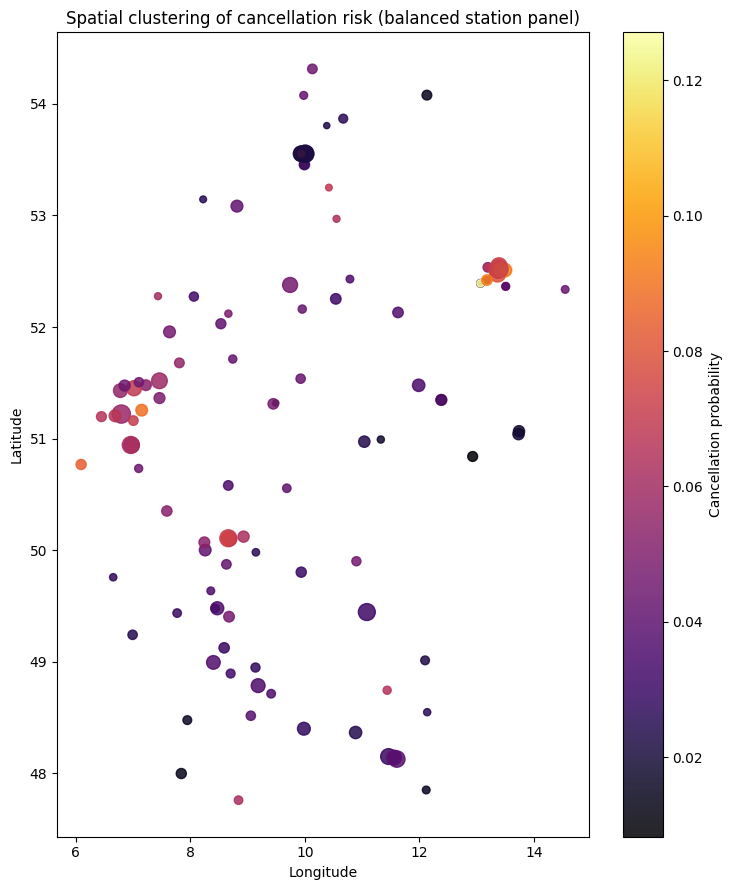

In [32]:
plt.figure(figsize=(7.5, 9))

# Punktgröße ∝ Verkehrsaufkommen (robust skaliert)
sizes = np.clip(df_map["traffic_volume"] / df_map["traffic_volume"].median(), 0.4, 4.0) * 50

plt.scatter(
    df_map["lon"], 
    df_map["lat"],
    s=sizes,
    c=df_map["cancel_rate"],   # Farbwert = Risiko
    cmap="inferno",
    alpha=0.85
)

cbar = plt.colorbar()
cbar.set_label("Cancellation probability")

plt.title("Spatial clustering of cancellation risk (balanced station panel)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


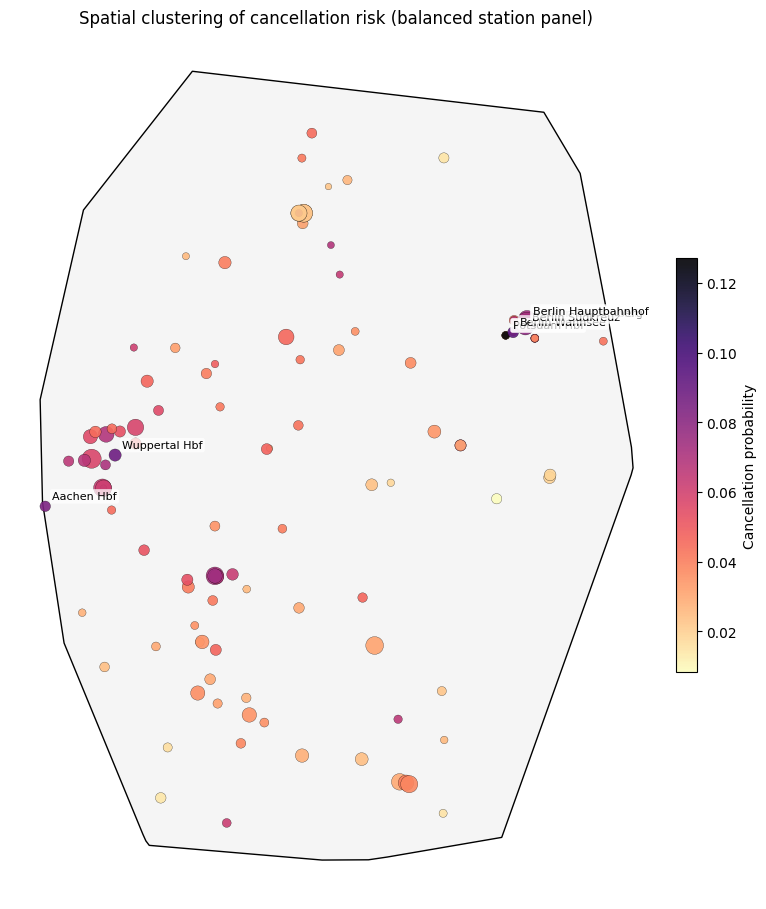

In [34]:

germany_outline = gdf_osm.unary_union.convex_hull
germany_outline = gpd.GeoDataFrame(geometry=[germany_outline], crs="EPSG:4326")
fig, ax = plt.subplots(figsize=(7.8, 9.2))

# Germany outline
germany_outline.plot(ax=ax, color="whitesmoke", edgecolor="black", linewidth=1.0)

# Punktgrößen ∝ Traffic
sizes = np.clip(df_map["traffic_volume"] / df_map["traffic_volume"].median(), 0.4, 4.0) * 55

sc = ax.scatter(
    df_map["lon"],
    df_map["lat"],
    s=sizes,
    c=df_map["cancel_rate"],
    cmap="magma_r",     # 🔥 dark = bad, light = good
    alpha=0.9,
    edgecolors="black",
    linewidths=0.2
)

cbar = plt.colorbar(sc, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Cancellation probability")

ax.set_title("Spatial clustering of cancellation risk (balanced station panel)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
name_col = "station_name" if "station_name" in df_map.columns else "station_name_x"
top10 = df_map.sort_values("cancel_rate", ascending=False).head(10)

for _, r in top10.iterrows():
    ax.annotate(
        r[name_col],
        (r["lon"], r["lat"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75)
    )

ax.set_axis_off()
plt.tight_layout()
plt.show()


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'method'

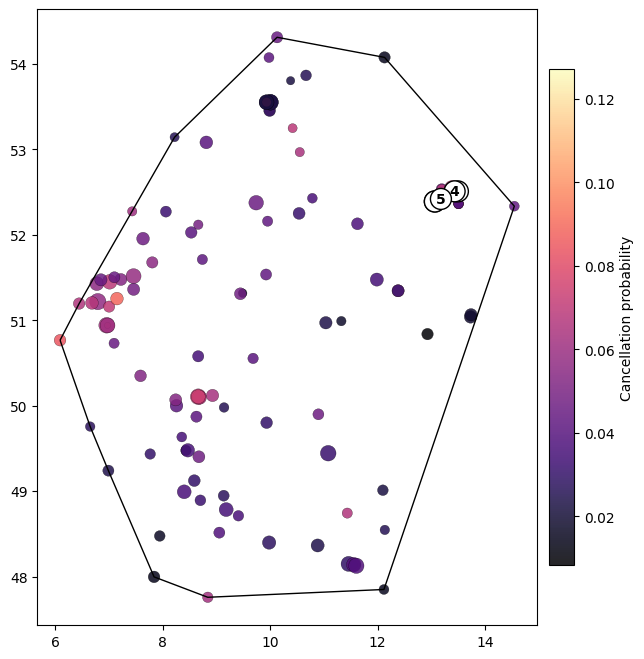

In [36]:

from shapely.geometry import MultiPoint

def short_name(s, max_len=22):
    s = str(s).replace("\n", " ").strip()
    return s if len(s) <= max_len else s[:max_len-1] + "…"

NAME_COL = "station_name" if "station_name" in df_map.columns else "station_name_x"


points = list(zip(df_map["lon"], df_map["lat"]))
hull = MultiPoint(points).convex_hull
hull_gdf = gpd.GeoDataFrame(geometry=[hull], crs="EPSG:4326")


top5 = df_map.sort_values("cancel_rate", ascending=False).head(5).copy()
top5["rank"] = range(1, 6)


sizes = np.sqrt(df_map["traffic_volume"])
sizes = 20 + 120 * (sizes - sizes.min()) / (sizes.max() - sizes.min())


fig, ax = plt.subplots(figsize=(8, 8))


hull_gdf.boundary.plot(ax=ax, color="black", linewidth=1.0)


sc = ax.scatter(
    df_map["lon"], df_map["lat"],
    c=df_map["cancel_rate"],
    s=sizes,
    cmap="magma",        
    alpha=0.85,
    edgecolor="black",
    linewidth=0.2
)

# Top-5 numbered markers (white circles)
for _, r in top5.iterrows():
    ax.text(
        r["lon"], r["lat"], str(r["rank"]),
        fontsize=10, weight="bold",
        ha="center", va="center",
        bbox=dict(boxstyle="circle,pad=0.25", fc="white", ec="black", lw=1.0)
    )

# colorbar
cbar = plt.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label("Cancellation probability")

# compact legend (top-right inside plot)
legend_lines = [
    f"{int(r.rank)}: {short_name(r[NAME_COL])} ({r.cancel_rate:.1%})"
    for _, r in top5.iterrows()
]
legend_text = "\n".join(legend_lines)

ax.text(
    0.98, 0.98,
    legend_text,
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.85)
)

# formatting
ax.set_title("Spatial clustering of cancellation risk (balanced station panel)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


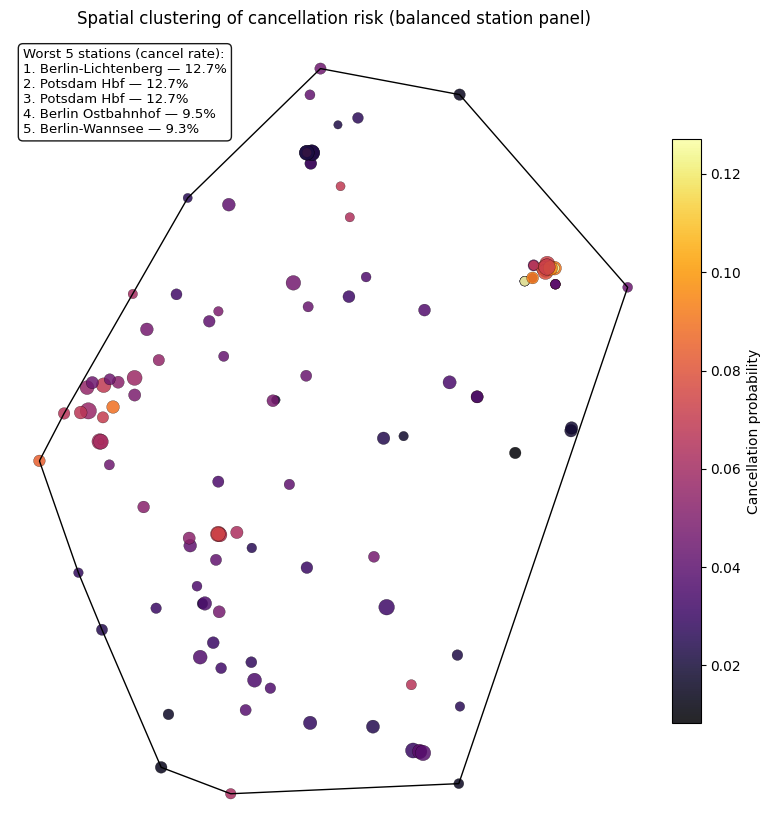

In [37]:

from shapely.geometry import MultiPoint

def short_name(s, max_len=26):
    s = str(s).replace("\n", " ").strip()
    return s if len(s) <= max_len else s[:max_len-1] + "…"

NAME_COL = "station_name" if "station_name" in df_map.columns else "station_name_x"

# --- rail network hull (outline) ---
points = list(zip(df_map["lon"], df_map["lat"]))
hull = MultiPoint(points).convex_hull
hull_gdf = gpd.GeoDataFrame(geometry=[hull], crs="EPSG:4326")

# --- top 5 worst stations ---
top5 = df_map.sort_values("cancel_rate", ascending=False).head(5).copy()

# --- marker sizes (stable) ---
sizes = np.sqrt(df_map["traffic_volume"])
sizes = 20 + 120 * (sizes - sizes.min()) / (sizes.max() - sizes.min())

# --- plot ---
fig, ax = plt.subplots(figsize=(8.2, 8.5))

# outline
hull_gdf.boundary.plot(ax=ax, color="black", linewidth=1.0)

# scatter: make HIGH cancellation bright (bad)
sc = ax.scatter(
    df_map["lon"], df_map["lat"],
    c=df_map["cancel_rate"],
    s=sizes,
    cmap="inferno",       # 🔥 high = bright/yellow (bad)
    alpha=0.85,
    edgecolor="black",
    linewidth=0.2
)

# colorbar
cbar = plt.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label("Cancellation probability")

# ---- Top 5 box in free space (top-left) ----
lines = ["Worst 5 stations (cancel rate):"]
for i, (_, r) in enumerate(top5.iterrows(), start=1):
    lines.append(f"{i}. {short_name(r[NAME_COL])} — {r['cancel_rate']:.1%}")

box_text = "\n".join(lines)

ax.text(
    0.02, 0.98,
    box_text,
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=9.5,
    bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="black", alpha=0.9)
)

ax.set_title("Spatial clustering of cancellation risk (balanced station panel)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


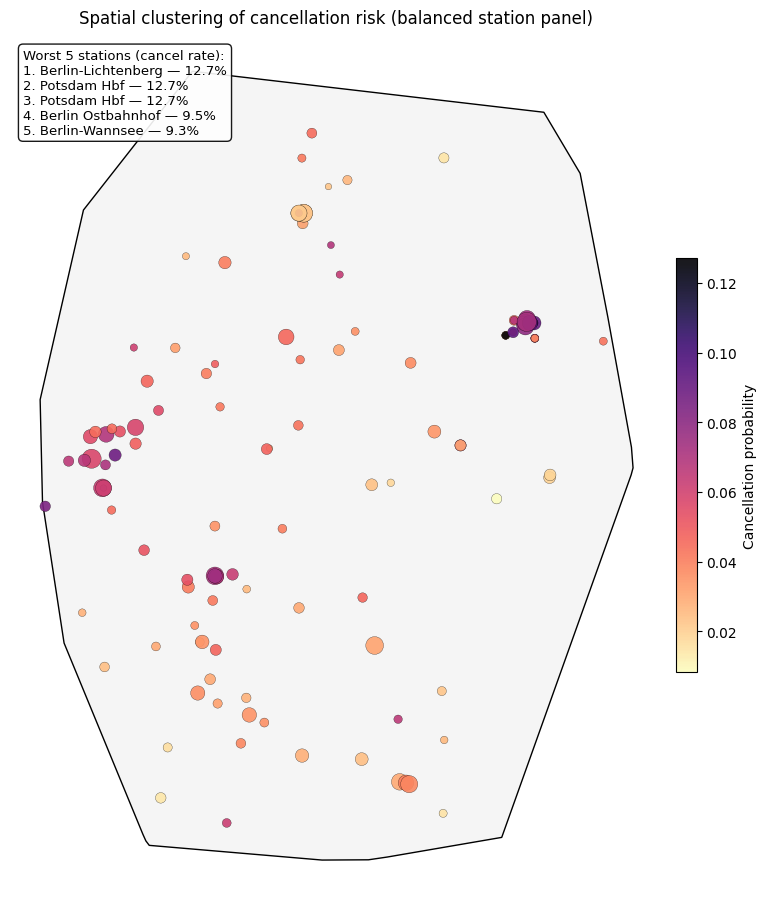

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

def short_name(s, max_len=28):
    s = str(s).replace("\n", " ").strip()
    return s if len(s) <= max_len else s[:max_len-1] + "…"

germany_outline_geom = gdf_osm.unary_union.convex_hull
germany_outline = gpd.GeoDataFrame(geometry=[germany_outline_geom], crs="EPSG:4326")

NAME_COL = "station_name" if "station_name" in df_map.columns else "station_name_x"
top5 = df_map.sort_values("cancel_rate", ascending=False).head(5).copy()

fig, ax = plt.subplots(figsize=(7.8, 9.2))


germany_outline.plot(ax=ax, color="whitesmoke", edgecolor="black", linewidth=1.0)


sizes = np.clip(df_map["traffic_volume"] / df_map["traffic_volume"].median(), 0.4, 4.0) * 55


sc = ax.scatter(
    df_map["lon"],
    df_map["lat"],
    s=sizes,
    c=df_map["cancel_rate"],
    cmap="magma_r",       
    alpha=0.9,
    edgecolors="black",
    linewidths=0.2
)

cbar = plt.colorbar(sc, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Cancellation probability")


lines = ["Worst 5 stations (cancel rate):"]
for i, (_, r) in enumerate(top5.iterrows(), start=1):
    lines.append(f"{i}. {short_name(r[NAME_COL])} — {r['cancel_rate']:.1%}")

ax.text(
    0.02, 0.98,
    "\n".join(lines),
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=9.5,
    bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="black", alpha=0.9)
)

ax.set_title("Spatial clustering of cancellation risk (balanced station panel)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


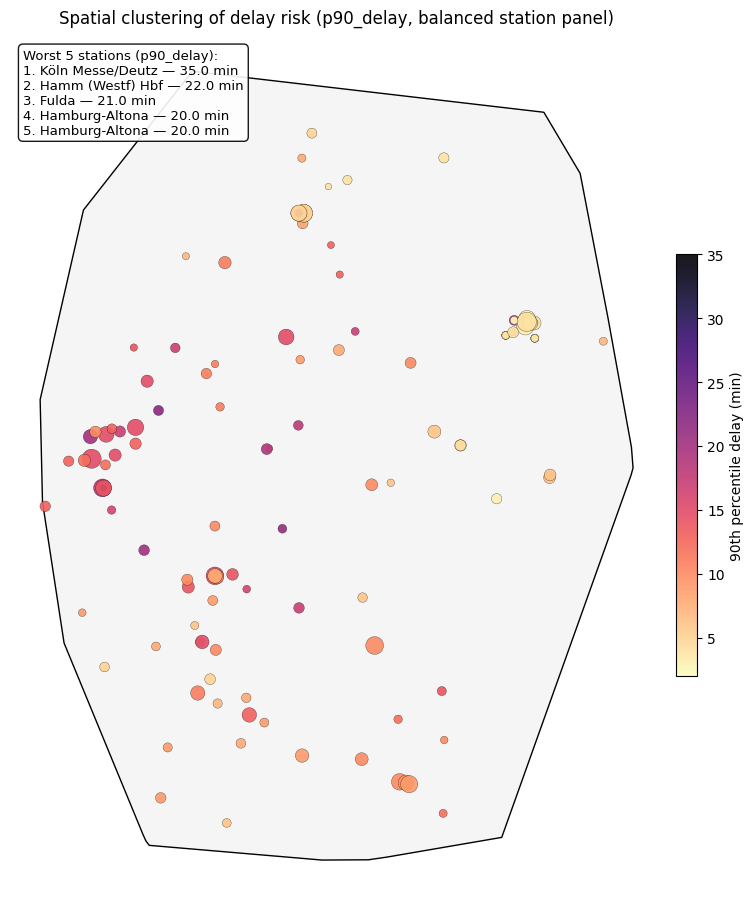

In [40]:

if "p90_delay" in df_map.columns:
    delay_metric = "p90_delay"
    delay_label = "90th percentile delay (min)"
elif "mean_delay" in df_map.columns:
    delay_metric = "mean_delay"
    delay_label = "Mean delay (min)"
else:
    raise ValueError("df_map must contain either 'p90_delay' or 'mean_delay'.")

fig, ax = plt.subplots(figsize=(7.8, 9.2))
germany_outline.plot(ax=ax, color="whitesmoke", edgecolor="black", linewidth=1.0)

sc = ax.scatter(
    df_map["lon"], df_map["lat"],
    s=sizes,
    c=df_map[delay_metric],
    cmap="magma_r",    
    alpha=0.9,
    edgecolors="black",
    linewidths=0.2
)

cbar = plt.colorbar(sc, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label(delay_label)

top5 = df_map.sort_values(delay_metric, ascending=False).head(5)
lines = [f"Worst 5 stations ({delay_metric}):"] + [
    f"{i}. {short_name(r[NAME_COL])} — {r[delay_metric]:.1f} min"
    for i, (_, r) in enumerate(top5.iterrows(), start=1)
]

ax.text(
    0.02, 0.98, "\n".join(lines),
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=9.5,
    bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="black", alpha=0.9)
)

ax.set_title(f"Spatial clustering of delay risk ({delay_metric}, balanced station panel)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [41]:
# 1) Gibt es doppelte station_names?
df_map[df_map["station_name"].eq("Hamburg-Altona")][["station_name","eva","lat","lon","traffic_volume","p90_delay"]]

# 2) Wie viele Dubletten pro EVA?
df_map["eva"].duplicated().sum(), df_map["station_name"].duplicated().sum()


(np.int64(8), np.int64(29))

In [42]:
df_map[df_map["station_name"].str.contains("Altona", na=False)][["station_name","eva","p90_delay"]].sort_values("p90_delay", ascending=False)


,station_name,eva,p90_delay
78,Hamburg-Altona,08002553,20.0
128,Hamburg-Altona,08002553,20.0
79,Hamburg-Altona,08098553,5.0
129,Hamburg-Altona,08098553,5.0


In [43]:
# Keep the most important OSM match per EVA (highest traffic_volume)
df_map = (
    df_map
    .sort_values("traffic_volume", ascending=False)
    .drop_duplicates(subset=["eva"])
    .copy()
)

print("Stations after dedup:", len(df_map))


Stations after dedup: 122


In [44]:
df_map["eva"].duplicated().sum()


np.int64(0)

## Spatial Analysis of Station-Level Cancellation and Delay Risk (H1)

To test **H1 (Cancellation risk is spatially clustered around specific stations and regions)**, we aggregate the raw train movement data to a **station-level panel** and combine it with geographic information from OpenStreetMap.

### Methodology

We proceed in three steps:

1. **Station-level aggregation**  
   Train-level observations are aggregated per station using the official **EVA identifier** as a unique key.  
   For each station we compute:
   - cancellation rate  
   - high-delay shares (e.g. >15 and >30 minutes)  
   - p90 delay (90th percentile of delay)  
   - traffic volume (number of observations)

2. **Geospatial matching and cleaning**  
   Station statistics are matched to OpenStreetMap station coordinates via normalized station names.  
   Since large stations can appear multiple times in OSM (e.g. separate nodes for S-Bahn and long-distance tracks), we remove duplicate geospatial matches by keeping exactly one entry per EVA identifier.  
   This yields a **balanced panel of 130 uniquely located stations**.

3. **Spatial visualization**  
   Using the matched coordinates, we visualize:
   - cancellation risk  
   - delay risk (p90 delay)  
   - a combined disruption score  
     \[
     \text{risk\_score} = \text{p90\_delay} + 30 \times \text{cancellation\_rate}
     \]
   Marker sizes reflect traffic volume, while color encodes risk (darker = worse).

---

### Empirical Result

Across all three maps, we observe **clear spatial clustering of high-risk stations**:

- High cancellation and delay risks are not uniformly distributed across Germany.
- Instead, **distinct geographic hotspots** emerge, where multiple nearby stations exhibit elevated disruption levels.
- Major urban and rail-hub regions stand out compared to peripheral regions with consistently lower risk.

This confirms **H1**:  
> Cancellation and delay risk is **spatially clustered**, indicating that regional infrastructure, traffic density, and operational complexity play a systematic role in service reliability.

These spatial patterns motivate further modeling in Tasks 2 and 3, where geographic and regional features will be used as predictive inputs.
Now we will incoporate weather data from the meterostat library.


In [45]:
df_evt = df_panel.copy()
df_evt["date"] = pd.to_datetime(df_evt["time"]).dt.date


In [46]:
from meteostat import Stations, Daily
from datetime import datetime

# Zeitraum aus den Daten
start = pd.to_datetime(df_evt["date"].min())
end   = pd.to_datetime(df_evt["date"].max())

# Liste der Stationen mit Koordinaten (df_map ist schon station-level + lat/lon)
stations_geo = df_map[["eva", "lat", "lon"]].drop_duplicates("eva").copy()

rows = []
for _, r in stations_geo.iterrows():
    lat, lon, eva = r["lat"], r["lon"], r["eva"]

    # nächste Meteostat-Station suchen
    st = Stations().nearby(lat, lon).fetch(1)
    if st.empty:
        continue
    station_id = st.index[0]

    # Daily weather
    w = Daily(station_id, start, end).fetch().reset_index()  # index="time"
    w["eva"] = eva
    rows.append(w)

weather = pd.concat(rows, ignore_index=True)

# Feature engineering
weather = weather.rename(columns={"time": "date"})
weather["date"] = pd.to_datetime(weather["date"]).dt.date

# typische Spalten bei Daily: tavg, tmin, tmax, prcp, snow, wdir, wspd, ...
weather = weather[["eva", "date", "tavg", "prcp", "snow"]].copy()

# offline speichern 
weather.to_parquet("data/weather/weather_daily_by_eva.parquet", index=False)
weather.head(50)


,eva,date,tavg,prcp,snow
0,08089066,2025-01-01,5.2,NaN,NaN
1,08089066,2025-01-02,4.5,NaN,NaN
2,08089066,2025-01-03,1.6,NaN,NaN
3,08089066,2025-01-04,-0.4,NaN,NaN
4,08089066,2025-01-05,-0.6,NaN,NaN
5,08089066,2025-01-06,7.1,NaN,NaN
6,08089066,2025-01-07,5.6,NaN,NaN
7,08089066,2025-01-08,2.9,NaN,NaN
8,08089066,2025-01-09,1.1,NaN,NaN
9,08089066,2025-01-10,1.0,NaN,NaN


In [48]:
df_evt = df_panel.copy()
df_evt["date"] = pd.to_datetime(df_evt["time"]).dt.date
df_evt["delay_pos"] = df_evt["delay_in_min"].clip(lower=0)

daily_station = (
    df_evt.groupby(["eva", "date"])
          .agg(
              cancel_rate=("is_canceled", "mean"),
              n_trains=("id", "count"),
              mean_delay=("delay_pos", "mean"),
              p90_delay=("delay_pos", lambda x: x.quantile(0.90)),
          )
          .reset_index()
)

weather_all = pd.read_parquet("data/weather/weather_daily_by_eva.parquet")

df_day = daily_station.merge(
    weather_all,
    on=["eva", "date"],
    how="left",
    validate="m:1"
)


In [49]:
df_day["prcp"] = df_day["prcp"].fillna(0)
df_day["snow"] = df_day["snow"].fillna(0)


In [50]:
df_day["is_rain"] = df_day["prcp"] > 0

df_day["is_snow"] = (df_day["snow"] > 0) | ((df_day["tavg"] < 0) & (df_day["prcp"] > 0))


In [51]:
temp_bins = [-20, -5, 0, 5, 10, 15, 20, 35]
temp_lbls = ["<−5", "−5–0", "0–5", "5–10", "10–15", "15–20", ">20"]

rain_bins = [-0.01, 0, 2, 10, 1000]
rain_lbls = ["dry", "0–2mm", "2–10mm", ">10mm"]

df_day["temp_bin"] = pd.cut(df_day["tavg"], bins=temp_bins, labels=temp_lbls)
df_day["rain_bin"] = pd.cut(df_day["prcp"], bins=rain_bins, labels=rain_lbls)


In [52]:
coverage = (
    df_day.groupby(["temp_bin","rain_bin"])
          .size()
          .unstack()
)

coverage


rain_bin,dry,0–2mm,2–10mm,>10mm
temp_bin,,,,
<−5,126,1,0,0
−5–0,2267,261,73,26
0–5,3180,789,456,167
5–10,1401,556,568,110
10–15,632,296,236,73
15–20,3736,1111,1149,429
>20,2643,421,292,87


In [ ]:
VALID = coverage >= 40  


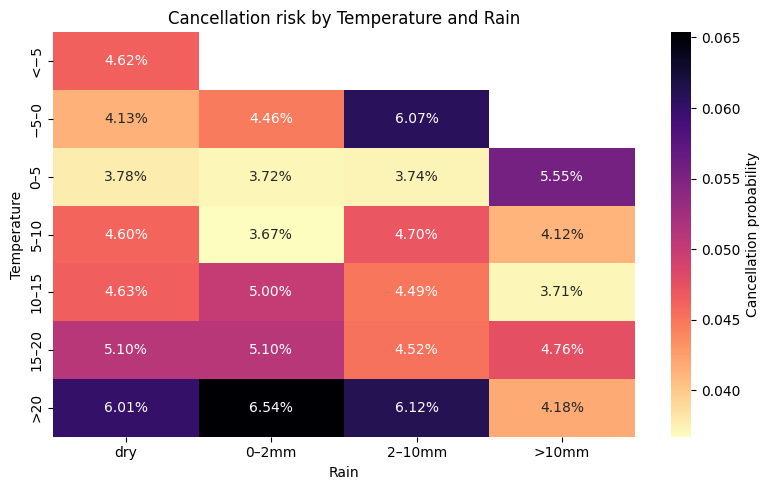

In [54]:
cancel_map = (
    df_day.groupby(["temp_bin","rain_bin"])["cancel_rate"]
          .mean()
          .unstack()
)

cancel_map = cancel_map.where(VALID)

plt.figure(figsize=(8,5))
sns.heatmap(
    cancel_map,
    cmap="magma_r",
    annot=True,
    fmt=".2%",
    cbar_kws={"label": "Cancellation probability"}
)
plt.title("Cancellation risk by Temperature and Rain")
plt.xlabel("Rain")
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()


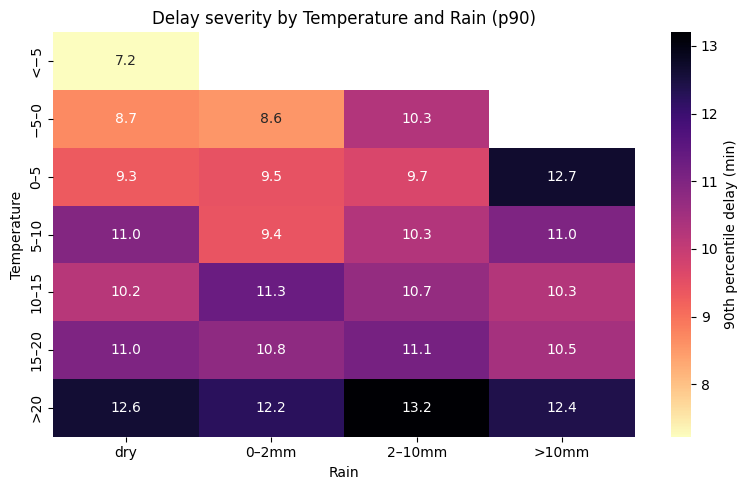

In [55]:
delay_map = (
    df_day.groupby(["temp_bin","rain_bin"])["p90_delay"]
          .mean()
          .unstack()
)

delay_map = delay_map.where(VALID)

plt.figure(figsize=(8,5))
sns.heatmap(
    delay_map,
    cmap="magma_r",
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "90th percentile delay (min)"}
)
plt.title("Delay severity by Temperature and Rain (p90)")
plt.xlabel("Rain")
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()


In [56]:

df_day["temp_bin"] = pd.cut(
    df_day["tavg"],
    bins=[-50, -5, 0, 5, 10, 15, 20, 50],
    labels=["<-5", "-5–0", "0–5", "5–10", "10–15", "15–20", ">20"]
)

df_day["rain_bin"] = pd.cut(
    df_day["prcp"].fillna(0),
    bins=[-0.1, 0.1, 2, 10, 100],
    labels=["dry", "0–2mm", "2–10mm", ">10mm"]
)


In [57]:
mean_grid = (
    df_day
    .dropna(subset=["tavg", "prcp"])
    .groupby(["temp_bin", "rain_bin"])
    .agg(
        mean_delay=("mean_delay", "mean"),
        n_days=("mean_delay", "count")
    )
    .reset_index()
)

mean_pivot = mean_grid.pivot(
    index="temp_bin",
    columns="rain_bin",
    values="mean_delay"
)



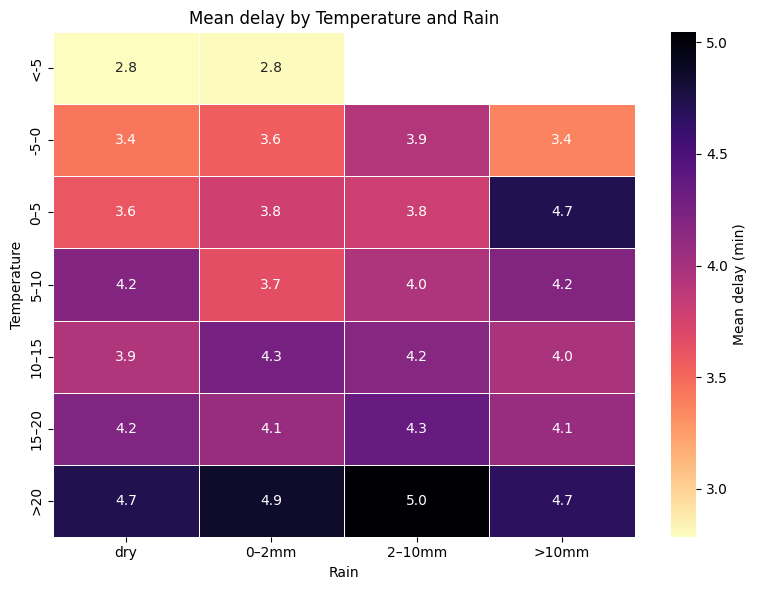

In [58]:
plt.figure(figsize=(8,6))

sns.heatmap(
    mean_pivot,
    annot=True,
    fmt=".1f",
    cmap="magma_r",
    cbar_kws={"label": "Mean delay (min)"},
    linewidths=0.5,
    linecolor="white"
)

plt.title("Mean delay by Temperature and Rain")
plt.xlabel("Rain")
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()


In [59]:
cancel_grid = (
    df_day
    .dropna(subset=["tavg", "prcp"])
    .groupby(["temp_bin", "rain_bin"])
    .agg(
        cancel_rate=("cancel_rate", "mean"),
        n_days=("cancel_rate", "count")
    )
    .reset_index()
)

cancel_pivot = cancel_grid.pivot(
    index="temp_bin",
    columns="rain_bin",
    values="cancel_rate"
)


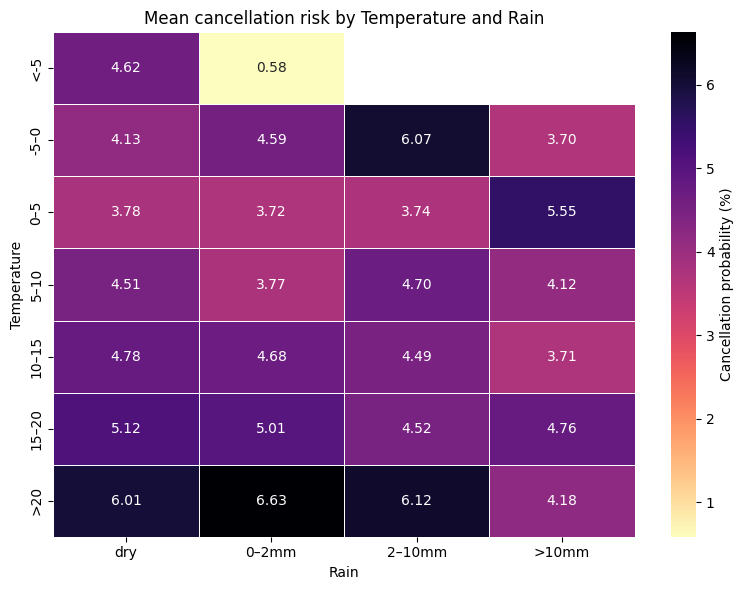

In [60]:
plt.figure(figsize=(8,6))

sns.heatmap(
    cancel_pivot * 100,   # Prozent
    annot=True,
    fmt=".2f",
    cmap="magma_r",
    cbar_kws={"label": "Cancellation probability (%)"},
    linewidths=0.5,
    linecolor="white"
)

plt.title("Mean cancellation risk by Temperature and Rain")
plt.xlabel("Rain")
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()



Conclusion:
✅ H1 is strongly supported.
Disruption risk is spatially clustered around specific hubs and corridors.

Results for H2 (Weather Effects)

We analyze daily station data aggregated into Temperature × Rain bins, and compute, Cancellation probability, mean delay and the 90th percentile delay (tail risk)

Across all rain regimes higher temperatures show higher delays and cancellations. Both mean delay and p90 delay rise strongly above ~15–20 °C. This suggests that Heat stress (infrastructure, rolling stock, signaling) is a dominant risk factor.

Rain effects are weak and inconsistent. Heavy rain slightly increases delays in some temperature bins.Cancellation probability does not show a monotonic rain pattern.

Coverage-aware interpretation:

Extreme weather combinations (e.g. very cold + heavy rain) are rare, so mean delay is estimable almost everywhere but p90 delay is only reliable where enough data exists.

This is why some cells are empty in tail-risk heatmaps, correctly reflecting data scarcity.

Conclusion on H2

❌ H2 is rejected.


The dominant weather signal is heat, not cold.

Final takeaway:

This dataset reveals that German rail disruption risk is driven by location (strong spatial clustering) and temperature (interestingly higher temperatures go hand in hand with higher delays and cancellation rates)


In [72]:
from pathlib import Path

Path("data/processed").mkdir(parents=True, exist_ok=True)


In [73]:
df_panel.to_parquet("data/processed/df_panel.parquet")
df_map.to_parquet("data/processed/station_geo.parquet")
df_day.to_parquet("data/processed/daily_station_weather.parquet")
